In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import folium
import json
import scipy

# sk
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

In [2]:
# Directory of the raw data files
_data_root = r'../data'

# Name of each data directory
_tides_root = r'tides'
_waves_root = r"waves"

### Loading the Data

In [3]:
# Ingesting data
# Creating original dataframe to concat - tides
df_tides = pd.DataFrame()
for file in os.listdir(os.path.join(_data_root, _tides_root)):
    df_tides_to_concat = pd.read_csv(os.path.join(_data_root, _tides_root, file), skiprows=[1])
    df_tides = pd.concat([df_tides, df_tides_to_concat])

# Creating original dataframe to concat - waves
df_waves = pd.DataFrame()
for file in os.listdir(os.path.join(_data_root, _waves_root)):
    df_waves_to_concat = pd.read_csv(os.path.join(_data_root, _waves_root, file), skiprows=[1])
    df_waves = pd.concat([df_waves, df_waves_to_concat])

In [4]:
# checking if all files have been correctly loaded

number_of_files_tides = len(os.listdir(os.path.join(_data_root, _tides_root)))
number_of_unique_stations_tides = df_tides['station_id'].nunique()

number_of_files_waves = len(os.listdir(os.path.join(_data_root, _waves_root)))
number_of_unique_stations_waves = df_waves['station_id'].nunique()

if number_of_files_tides != number_of_unique_stations_tides or number_of_files_waves != number_of_unique_stations_waves:
    print('Number of files different than unique stations.')
else:
    print('All files have been loaded correctly.')

All files have been loaded correctly.


In [5]:
# Transforming time columns

df_waves['time'] = pd.to_datetime(df_waves['time'])
df_tides['time'] = pd.to_datetime(df_tides['time'])

df_waves['time'] = df_waves['time'].dt.tz_localize(None)
df_tides['time'] = df_tides['time'].dt.tz_localize(None)

In [6]:
df_waves.shape

(250992, 12)

### 1. Build a Time Series model that can predict the sea temperature throughout the year

### EDA

In [7]:
df_waves.head()

,longitude,latitude,time,station_id,PeakPeriod,PeakDirection,UpcrossPeriod,SignificantWaveHeight,Hmax,SeaTemperature,MeanCurSpeed,MeanCurDirTo
0,-9.262278,53.228333,2021-09-16 00:05:00,SmartBay Wave Buoy,NaN,NaN,NaN,NaN,NaN,16.72,NaN,NaN
1,-9.262278,53.228333,2021-09-16 00:10:00,SmartBay Wave Buoy,NaN,NaN,NaN,NaN,NaN,16.72,0.108,23.912088
2,-9.262278,53.228333,2021-09-16 00:15:00,SmartBay Wave Buoy,NaN,NaN,NaN,NaN,NaN,16.72,NaN,NaN
3,-9.262278,53.228333,2021-09-16 00:20:00,SmartBay Wave Buoy,NaN,NaN,NaN,NaN,NaN,16.72,0.138,29.010988
4,-9.262278,53.228333,2021-09-16 00:25:00,SmartBay Wave Buoy,NaN,NaN,NaN,NaN,NaN,16.72,NaN,NaN


In [8]:
df_waves.tail()

,longitude,latitude,time,station_id,PeakPeriod,PeakDirection,UpcrossPeriod,SignificantWaveHeight,Hmax,SeaTemperature,MeanCurSpeed,MeanCurDirTo
16564,-10.15099,54.2251,2022-09-05 21:32:00,AMETS Berth B Wave Buoy,9.09,233.4,4.819,112.0,NaN,15.2,NaN,NaN
16565,-10.15099,54.2251,2022-09-05 22:02:00,AMETS Berth B Wave Buoy,10.00,232.0,4.762,123.0,NaN,15.2,NaN,NaN
16566,-10.15099,54.2251,2022-09-05 22:32:00,AMETS Berth B Wave Buoy,10.53,229.2,5.000,123.0,NaN,15.2,NaN,NaN
16567,-10.15099,54.2251,2022-09-05 23:02:00,AMETS Berth B Wave Buoy,10.53,229.2,5.714,140.0,NaN,15.2,NaN,NaN
16568,-10.15099,54.2251,2022-09-05 23:32:00,AMETS Berth B Wave Buoy,10.53,229.2,5.333,140.0,NaN,15.2,NaN,NaN


We can see that the time interval between measures it is not regular, on the beginning it is collected every 5 minutes, and later every 30 minutes.

In [9]:
# check for nulls
df_waves.isnull().sum()

longitude                     0
latitude                      0
time                          0
station_id                    0
PeakPeriod               173310
PeakDirection            173310
UpcrossPeriod            173310
SignificantWaveHeight    173310
Hmax                     216370
SeaTemperature                0
MeanCurSpeed             198428
MeanCurDirTo             198431
dtype: int64

We have a lot of missing data. Judging the name of the column, it was values collected to state aggregations per period.

In [10]:
df_waves.describe()

,longitude,latitude,PeakPeriod,PeakDirection,UpcrossPeriod,SignificantWaveHeight,Hmax,SeaTemperature,MeanCurSpeed,MeanCurDirTo
count,250992.000000,250992.000000,77682.000000,77682.000000,77682.000000,77682.000000,34622.000000,250992.000000,52564.000000,52561.000000
mean,-9.716230,52.629164,10.258620,267.979840,5.741876,184.508664,143.025995,12.297332,0.101646,173.233028
std,0.345750,0.941411,3.259992,54.317685,1.898708,161.773999,111.588810,3.170566,0.076782,103.141230
min,-10.297370,51.647000,1.350000,0.000000,1.490000,0.000000,6.000000,4.470000,0.000000,0.000000
25%,-10.094833,51.647000,8.330000,246.153840,4.280000,68.000000,62.000000,9.550000,0.046000,77.890110
50%,-9.681000,52.282333,10.530000,270.000000,5.634000,138.000000,114.000000,11.900000,0.080000,165.362640
75%,-9.262278,53.228333,12.500000,303.912080,7.080000,249.000000,190.000000,14.730000,0.137000,268.219800
max,-9.262278,54.275300,25.000000,359.648350,21.970000,1819.000000,1407.000000,22.360000,1.363000,359.912080


At a first look, we can see that maybe there are outliers, let's see it more visually.

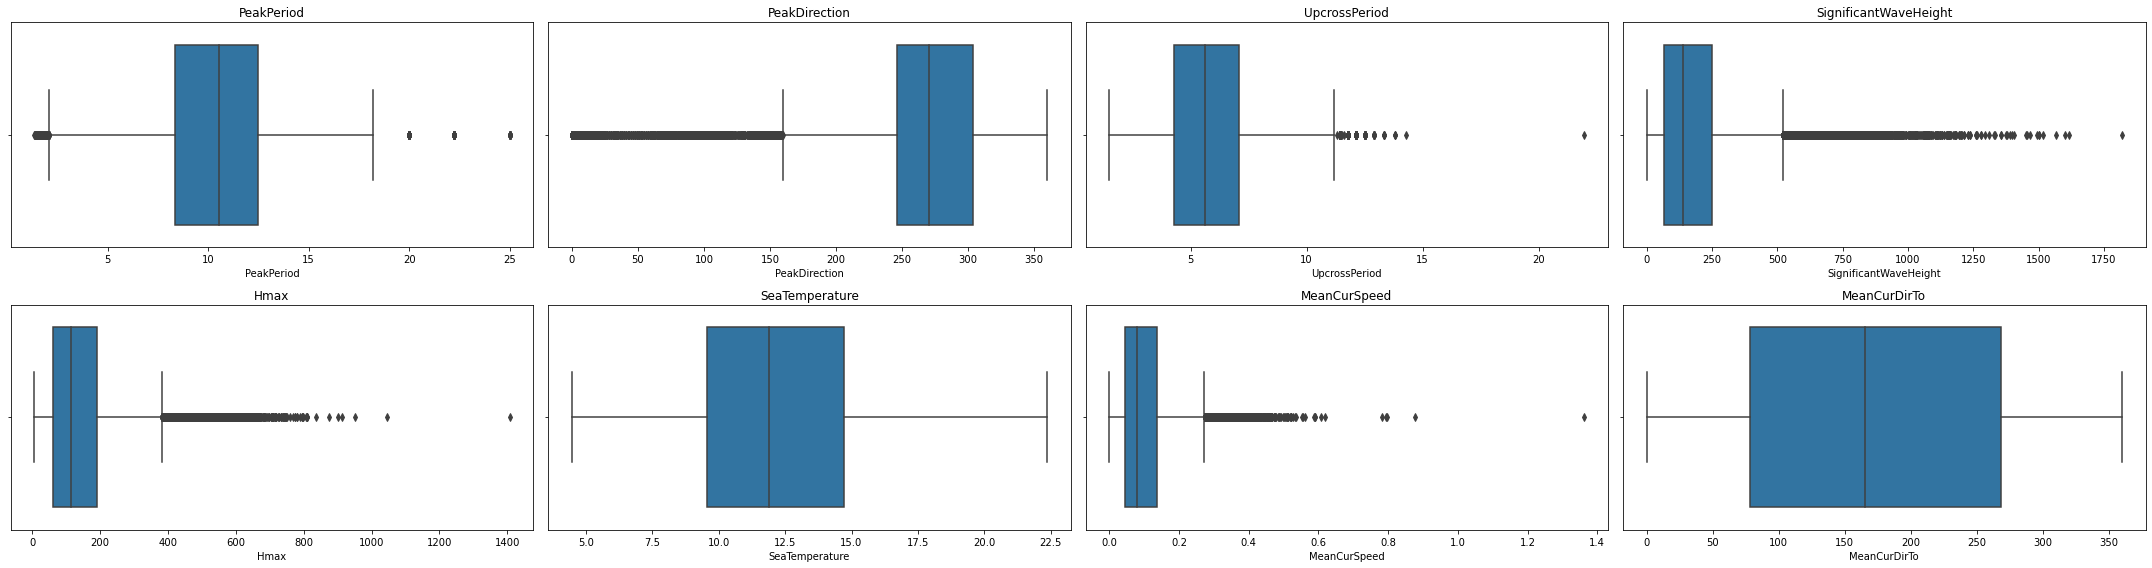

In [11]:
plt.figure(figsize=(30, 8))

columns = ['PeakPeriod', 'PeakDirection', 'UpcrossPeriod', 'SignificantWaveHeight', 'Hmax', 'SeaTemperature', 'MeanCurSpeed', 'MeanCurDirTo']

i = 1
for column in columns:
    plt.subplot(2, 4, i)
    plt.title(column)
    sns.boxplot(x=df_waves[column])    
    i+=1

plt.tight_layout()
plt.show()

Now we can see more clearly that there are some outliers, but they look like more a natural event than an error on the measuring. Therefore, we will not perform any changes.

#### Model

I chose to the Prophet library for creating my model and analyzing the data trends.

In [12]:
from prophet import Prophet
from dateutil.relativedelta import relativedelta

In [13]:
df_waves

,longitude,latitude,time,station_id,PeakPeriod,PeakDirection,UpcrossPeriod,SignificantWaveHeight,Hmax,SeaTemperature,MeanCurSpeed,MeanCurDirTo
0,-9.262278,53.228333,2021-09-16 00:05:00,SmartBay Wave Buoy,NaN,NaN,NaN,NaN,NaN,16.72,NaN,NaN
1,-9.262278,53.228333,2021-09-16 00:10:00,SmartBay Wave Buoy,NaN,NaN,NaN,NaN,NaN,16.72,0.108,23.912088
2,-9.262278,53.228333,2021-09-16 00:15:00,SmartBay Wave Buoy,NaN,NaN,NaN,NaN,NaN,16.72,NaN,NaN
3,-9.262278,53.228333,2021-09-16 00:20:00,SmartBay Wave Buoy,NaN,NaN,NaN,NaN,NaN,16.72,0.138,29.010988
4,-9.262278,53.228333,2021-09-16 00:25:00,SmartBay Wave Buoy,NaN,NaN,NaN,NaN,NaN,16.72,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
16564,-10.150990,54.225100,2022-09-05 21:32:00,AMETS Berth B Wave Buoy,9.09,233.4,4.819,112.0,NaN,15.20,NaN,NaN
16565,-10.150990,54.225100,2022-09-05 22:02:00,AMETS Berth B Wave Buoy,10.00,232.0,4.762,123.0,NaN,15.20,NaN,NaN
16566,-10.150990,54.225100,2022-09-05 22:32:00,AMETS Berth B Wave Buoy,10.53,229.2,5.000,123.0,NaN,15.20,NaN,NaN
16567,-10.150990,54.225100,2022-09-05 23:02:00,AMETS Berth B Wave Buoy,10.53,229.2,5.714,140.0,NaN,15.20,NaN,NaN


In [14]:
# let's create a split date to split our data based on time because it is a time series and the chronological order is very important
final_date = df_waves['time'].max()
# I chose to split the data 2 months in the past to predict these 2 months
split_date = final_date + relativedelta(months=-2)

# since the data is not symmetrically spaced, let's group it into a 30 minute interval and get the mean of the period
# but why 30 min? We see that our max interval between dates were 30 min, if we get less than that, there would be some nan values.
# prophet demands that the time columns is named 'ds' and the target is named 'y', so let's rename it
df_waves_grouped_per_30_minutes = df_waves.groupby([pd.Grouper(key='time', freq='30Min')]).mean().reset_index().rename(columns={'time': 'ds', 'SeaTemperature': 'y'})[['ds', 'y']].copy()

# split the data into train and test
train = df_waves_grouped_per_30_minutes[df_waves_grouped_per_30_minutes['ds'] < split_date]
val = df_waves_grouped_per_30_minutes[df_waves_grouped_per_30_minutes['ds'] >= split_date]

train.shape, val.shape

((14586, 2), (2976, 2))

In [15]:
# check if there are null values
print(train.isnull().sum())
print(val.isnull().sum())

ds    0
y     0
dtype: int64
ds    0
y     0
dtype: int64


In [16]:
# checking if the data interval it is correct
train.head()

,ds,y
0,2021-09-16 00:00:00,16.241765
1,2021-09-16 00:30:00,16.263000
2,2021-09-16 01:00:00,16.230000
3,2021-09-16 01:30:00,16.233000
4,2021-09-16 02:00:00,16.244000


In [17]:
val.head()

,ds,y
14586,2022-07-16 21:00:00,18.321333
14587,2022-07-16 21:30:00,18.306667
14588,2022-07-16 22:00:00,18.260667
14589,2022-07-16 22:30:00,18.237333
14590,2022-07-16 23:00:00,18.211333


In [18]:
# instantiate the model
model = Prophet(
changepoint_prior_scale= 0.5,
seasonality_prior_scale= 10.0, 
seasonality_mode= 'additive'
)

# fit the model
model.fit(train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [19]:
# creating a future dataframe to predict with the shape of the validation
future = model.make_future_dataframe(periods=val.shape[0], freq='30Min')

In [20]:
future.tail()

,ds
17557,2022-09-16 18:30:00
17558,2022-09-16 19:00:00
17559,2022-09-16 19:30:00
17560,2022-09-16 20:00:00
17561,2022-09-16 20:30:00


In [21]:
fcst = model.predict(future)

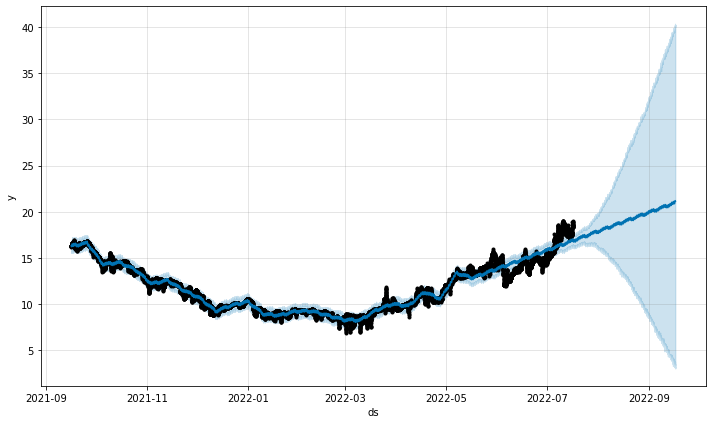

In [22]:
fig = model.plot(fcst)

In [23]:
# Create two functions to help us visualize the difference between predictions and real values

In [24]:
def make_verif(forecast, data_train, data_test): 
    """
    Put together the forecast (coming from fbprophet) 
    and the overved data, and set the index to be a proper datetime index, 
    for plotting
    Parameters
    ----------
    forecast : pandas.DataFrame 
        The pandas.DataFrame coming from the `forecast` method of a fbprophet 
        model. 
    
    data_train : pandas.DataFrame
        The training set, pandas.DataFrame
    data_test : pandas.DataFrame
        The training set, pandas.DataFrame
    
    Returns
    -------
    forecast : 
        The forecast DataFrane including the original observed data.
    """
    
    forecast.index = pd.to_datetime(forecast.ds)
    
    data_train.index = pd.to_datetime(data_train.ds)
    
    data_test.index = pd.to_datetime(data_test.ds)
    
    data = pd.concat([data_train, data_test], axis=0)
    
    forecast.loc[:,'y'] = data.loc[:,'y']
    
    return forecast

In [25]:
def plot_verif(verif, data_train):
    """
    plots the forecasts and observed data, the `data_train` argument is used to visualise 
    the division between the training and test sets. 
    Parameters
    ----------
    verif : pandas.DataFrame
        The `verif` DataFrame coming from the `make_verif` function in this package
    data_train : pandas.DataFrame
        The training set, pandas.DataFrame
    Returns
    -------
    f : matplotlib Figure object
    """
    
    f, ax = plt.subplots(figsize=(14, 8))
    
    train = verif[data_train.shape[0]:]
    
    ax.plot(train.index, train.y, 'ro', markersize=3)
    
    ax.plot(train.index, train.yhat, color='steelblue', lw=0.5)
    
    ax.fill_between(train.index, train.yhat_lower, train.yhat_upper, color='steelblue', alpha=0.3)
    
    test = verif[:data_train.shape[0]]
    
    ax.plot(test.index, test.y, 'ko', markersize=3)
    
    ax.plot(test.index, test.yhat, color='coral', lw=0.5)
    
    ax.fill_between(test.index, test.yhat_lower, test.yhat_upper, color='coral', alpha=0.3)
    
    ax.axvline(data_train.iloc[-1]['ds'].strftime("%Y-%m-%d %H:%M:%S"), color='0.2', alpha=0.7)
    
    ax.grid(ls=':', lw=0.5)
    
    return f

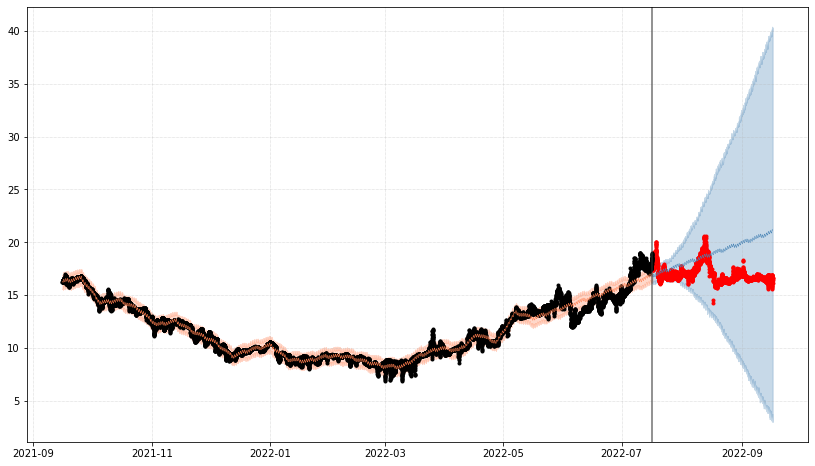

In [26]:
# veryfing the predicted and actual observations
verif = make_verif(fcst, train, val)
plot_evaluate = plot_verif(verif, train)

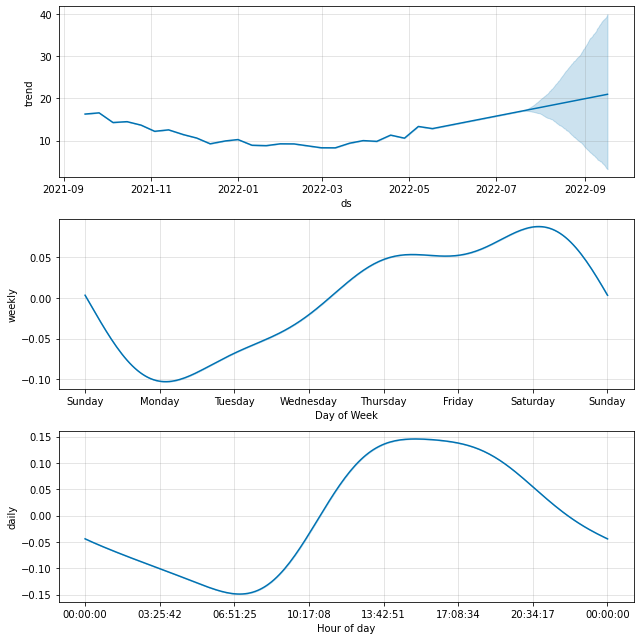

In [27]:
# components of the model
fig = model.plot_components(fcst)

In [28]:
# calculating metrics to see the performance of the train and test sets
real_train_values = model.history
real_test_values = val.copy()
predicted_values_train = fcst[:model.history.shape[0]]
predicted_values_test = fcst[model.history.shape[0]:]

rmse_train = mean_squared_error(real_train_values['y'], predicted_values_train['yhat'], squared=False)
mae_train = mean_absolute_error(real_train_values['y'], predicted_values_train['yhat'])
r2score_train = r2_score(real_train_values['y'], predicted_values_train['yhat'])
mape_train = mean_absolute_percentage_error(real_train_values['y'], predicted_values_train['yhat'])

rmse_test = mean_squared_error(real_test_values['y'], predicted_values_test['yhat'], squared=False)
mae_test = mean_absolute_error(real_test_values['y'], predicted_values_test['yhat'])
r2score_test = r2_score(real_test_values['y'], predicted_values_test['yhat'])
mape_test = mean_absolute_percentage_error(real_test_values['y'], predicted_values_test['yhat'])

In [29]:
df_metrics_eval = pd.DataFrame(
    [{
        "rmse_train": rmse_train,
        "mae_train": mae_train,
        "mape_train": mape_train,
        "r2_train": r2score_train,
        "rmse_test": rmse_test,
        "mae_test": mae_test,
        "mape_test": mape_test,
        "r2_test": r2score_test,
    }]
)

In [31]:
df_metrics_eval

,rmse_train,mae_train,mape_train,r2_train,rmse_test,mae_test,mape_test,r2_test
0,0.50866,0.342025,0.027945,0.963163,2.526067,2.097714,0.125514,-8.943772


The model seems to overfit a lot, and it doesn't provide good predictions. On the train data it provides very good results, with low rmse and a high r2_score, but in the test data the metrics get a lot worse.

We can see on the chart that it captures the tendency to grow, but the model ignore that there are a strong seasonality due to the seasons of the year and the temperature can't continuous grow like that.

Another way to improve the model it was passing the location, enhancing the predict.

The model need to be optimized to capture these seasonalities and predict with more accuracy. Since we only collected data for a year, I am sure that if we had data on more years, the model would capture these patterns in a better way.

### 2. Group the oceans using a machine learning model suited to this task. (Recommended use of Python)


### EDA

In [32]:
# sorting the dataset
df_tides = df_tides.sort_values(by='time')

In [33]:
df_tides

,time,station_id,latitude,longitude,Water_Level_LAT,Water_Level_OD_Malin,QC_Flag
0,2021-09-16 00:05:00,Dingle Harbour,52.13924,-10.27732,3.346,0.791,1
0,2021-09-16 00:05:00,Ballyglass Harbour,54.25360,-9.89280,2.669,0.565,1
0,2021-09-16 00:05:00,Roonagh Pier,53.76235,-9.90442,3.144,1.189,0
0,2021-09-16 00:05:00,Wexford Harbour,52.33850,-6.45890,1.177,0.221,1
0,2021-09-16 00:05:00,Skerries Harbour,53.58500,-6.10810,1.647,-1.212,0
...,...,...,...,...,...,...,...
98954,2022-09-16 20:25:00,Dingle Harbour,52.13924,-10.27732,3.481,0.926,0
96735,2022-09-16 20:25:00,Aranmore Island - Leabgarrow,54.99050,-8.49550,2.787,0.584,0
104396,2022-09-16 20:25:00,Ballyglass Harbour,54.25360,-9.89280,2.790,0.686,0
52473,2022-09-16 20:25:00,Ballycotton Harbour,51.82780,-8.00070,3.642,1.153,0


In [34]:
df_tides.shape

(1330778, 7)

In [52]:
# Since we will build clusters, let's group the data into every station_id
df_tides_grouped_per_station = df_tides.groupby(['station_id']).mean().reset_index()

In [53]:
df_tides_grouped_per_station

,station_id,latitude,longitude,Water_Level_LAT,Water_Level_OD_Malin,QC_Flag
0,Aranmore Island - Leabgarrow,54.990500,-8.49550,2.237245,0.034245,0.930047
1,Ballycotton Harbour,51.827800,-8.00070,2.384431,-0.104569,0.871555
2,Ballyglass Harbour,54.253600,-9.89280,2.024153,-0.079847,0.935218
3,Castletownbere Port,51.649600,-9.90340,1.882076,-0.207924,0.920984
4,Dingle Harbour,52.139240,-10.27732,2.489094,-0.065906,0.931706
5,Dublin Port,53.345700,-6.22170,2.519070,0.014070,0.000000
6,Galway Port,53.269000,-9.04800,2.999361,0.032361,0.935729
7,Howth Water Level 1,53.391335,-6.06809,NaN,-0.080356,0.933877
8,Killybegs Port,54.636400,-8.39490,2.332173,0.039173,0.917704
9,Kinvara - Unreferenced,53.140520,-8.93758,NaN,-2.365941,0.831120


In [54]:
# Check for missing data
df_tides_grouped_per_station.isnull().sum()

station_id              0
latitude                0
longitude               0
Water_Level_LAT         3
Water_Level_OD_Malin    0
QC_Flag                 0
dtype: int64

### Model

We will be using the model that is considered one of the simplest models amongst clustering. Despite its simplicity, the **K-means** is vastly used for clustering in many data science applications, it is especially useful if you need to quickly discover insights from **unlabeled data**.

In [55]:
from sklearn.cluster import KMeans 

In [56]:
# to instantiate our model, let's define the number of clusters to form as well as the number of centroids to generate.
# and the n_init that is the number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia.
k_means = KMeans(init = "k-means++", n_clusters = 4, n_init = 12)

In [57]:
# fit the model
k_means.fit(df_tides_grouped_per_station[['Water_Level_OD_Malin', 'QC_Flag']])

KMeans(n_clusters=4, n_init=12)

In [58]:
# see the labels
k_means_labels = k_means.labels_
k_means_labels

array([0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 3, 2, 0, 0, 0])

In [59]:
# check the centers
k_means_cluster_centers = k_means.cluster_centers_
k_means_cluster_centers

array([[-0.06463943,  0.92189249],
       [-2.36594059,  0.83111979],
       [-0.03834625,  0.        ],
       [ 0.47070788,  0.        ]])

In [60]:
# insert the cluster label to our dataset
df_tides_grouped_per_station.insert(0, 'Cluster Labels', k_means.labels_)

In [61]:
# print the number of records in each cluster
for cluster in np.sort(df_tides_grouped_per_station['Cluster Labels'].unique()):
    print(f'There are {df_tides_grouped_per_station.loc[df_tides_grouped_per_station["Cluster Labels"] == cluster].shape[0]} registers on Cluster {cluster}')

There are 11 registers on Cluster 0
There are 1 registers on Cluster 1
There are 2 registers on Cluster 2
There are 1 registers on Cluster 3


In [62]:
df_tides_grouped_per_station.groupby('Cluster Labels')[['Water_Level_OD_Malin', 'QC_Flag']].describe()

Water_Level_OD_Malin                                          \
                              count      mean       std       min       25%   
Cluster Labels                                                                
0                              11.0 -0.064639  0.089624 -0.207924 -0.099573   
1                               1.0 -2.365941       NaN -2.365941 -2.365941   
2                               2.0 -0.038346  0.074128 -0.090763 -0.064554   
3                               1.0  0.470708       NaN  0.470708  0.470708   

                                             QC_Flag                      \
                     50%       75%       max   count      mean       std   
Cluster Labels                                                             
0              -0.079847  0.026600  0.039173    11.0  0.921892  0.021114   
1              -2.365941 -2.365941 -2.365941     1.0  0.831120       NaN   
2              -0.038346 -0.012138  0.014070     2.0  0.000000  0.000000   
3               0.470708  0.470708  0.470708     1.0  0.000000       NaN   

                                                                  
                     min       25%       50%       75%       max  
Cluster Labels                                                    
0               0.871555  0.919344  0.931706  0.935308  0.935892  
1               0.831120  0.831120  0.831120  0.831120  0.831120  
2               0.000000  0.000000  0.000000  0.000000  0.000000  
3               0.000000  0.000000  0.000000  0.000000  0.000000

Analyzing the statistics:
- Cluster nº 0 have the majority of the stations in it, this means that the stations were too similar or we don't have enough data about it to differentiate them
- We see that the cluster nº 3 have the highest water level mean between them, and the cluster nº 1 have the lowest.

In [63]:
final_map = folium.Map(location=[53.269, -9.048], zoom_start=7)

for lat, lng, label, water_level, station in zip(df_tides_grouped_per_station['latitude'], df_tides_grouped_per_station['longitude'], df_tides_grouped_per_station['Cluster Labels'], df_tides_grouped_per_station['Water_Level_OD_Malin'], df_tides_grouped_per_station['station_id']):
    if label == 0:
        color='red'
    elif label == 1:
        color='green'
    elif label == 2:
        color='yellow'
    elif label == 3:
        color='grey'

    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=f"{station}, {water_level}, {label}",
        fill=True,
        color=color,
        fill_color=color,
        fill_opacity=0.6
    ).add_to(final_map)


final_map

The clusters didn't seem to be influenced by the localization of the station. 

To improve the analysis we would need more features about each station, so the model could better capture the patterns.